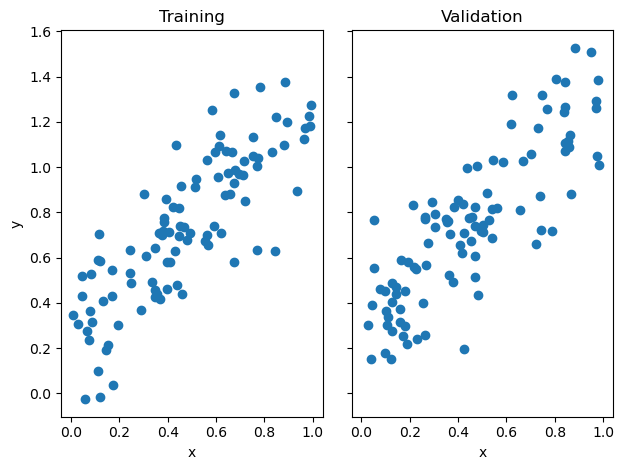

In [73]:
%reload_ext autoreload 
%autoreload 2

import numpy as np
from linearRegression import LinearRegression
from matplotlib import pyplot as plt


def pad(X):
    return np.append(X, np.ones((X.shape[0], 1)), 1)

def LR_data(n_train = 100, n_val = 100, p_features = 1, noise = .1, w = None):
    if w is None: 
        w = np.random.rand(p_features + 1) + .2
    
    X_train = np.random.rand(n_train, p_features)
    y_train = pad(X_train)@w + noise*np.random.randn(n_train)

    X_val = np.random.rand(n_val, p_features)
    y_val = pad(X_val)@w + noise*np.random.randn(n_val)
    
    return X_train, y_train, X_val, y_val



n_train = 100
n_val = 100
p_features = 1
noise = 0.2

# create some data
X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)

# plot it
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_train, y_train)
axarr[1].scatter(X_val, y_val)
labs = axarr[0].set(title = "Training", xlabel = "x", ylabel = "y")
labs = axarr[1].set(title = "Validation", xlabel = "x")
plt.tight_layout()



Training score = 0.6837
Validation score = 0.6899
Training score = 0.5028
Validation score = 0.5113


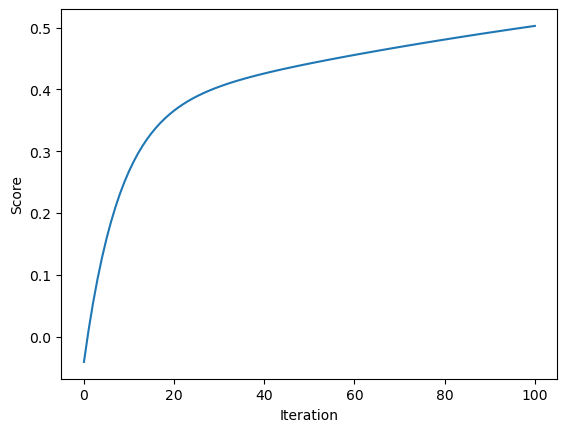

In [74]:
LR = LinearRegression()
LR.fit_analytical(X_train, y_train) # I used the analytical formula as my default fit method

print(f"Training score = {LR.score(X_train, y_train).round(4)}")
print(f"Validation score = {LR.score(X_val, y_val).round(4)}")

LR2 = LinearRegression()
LR2.fit_gradient(X_train, y_train, alpha = 0.0005) 

print(f"Training score = {LR2.score(X_train, y_train).round(4)}")
print(f"Validation score = {LR2.score(X_val, y_val).round(4)}")

plt.plot(LR2.score_history)
labels = plt.gca().set(xlabel = "Iteration", ylabel = "Score")
plt.show()


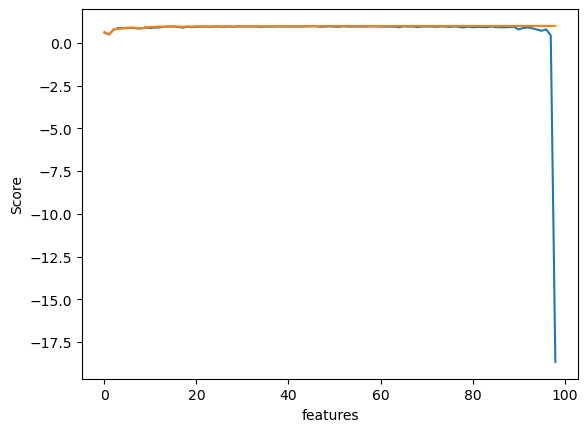

In [75]:
n_train = 100
n_val = 100
noise = 0.2

number_features = []  
validation_score = [] 
training_score = []

LR = LinearRegression()

for p_features in range(1, n_val):
    number_features.append(p_features)
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    LR.fit_analytical(X_train, y_train)
    validation_score.append(LR.score(X_val, y_val))
    training_score.append(LR.score(X_train, y_train))

plt.plot(validation_score, label = "Validation Scores")
plt.plot(training_score, label = "Training Scores")
labels = plt.gca().set(xlabel = "features", ylabel = "Score")
plt.show()
    

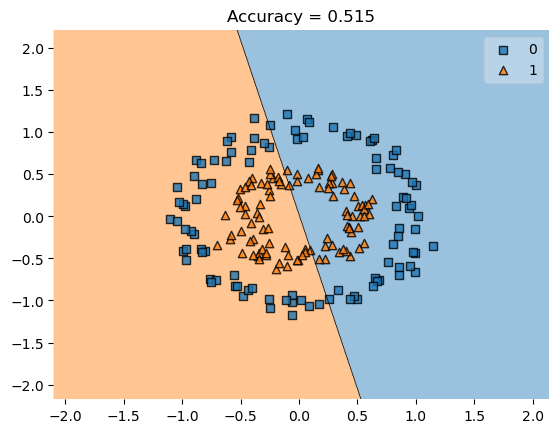

In [100]:
from sklearn.datasets import make_moons, make_circles
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import numpy as np
np.seterr(all="ignore")

X, y = make_circles(200, shuffle = True, noise = 0.1, factor = 0.5)

LR = LogisticRegression()
LR.fit(X, y)
plot_decision_regions(X, y, clf = LR)
score = plt.gca().set_title(f"Accuracy = {LR.score(X, y)}")



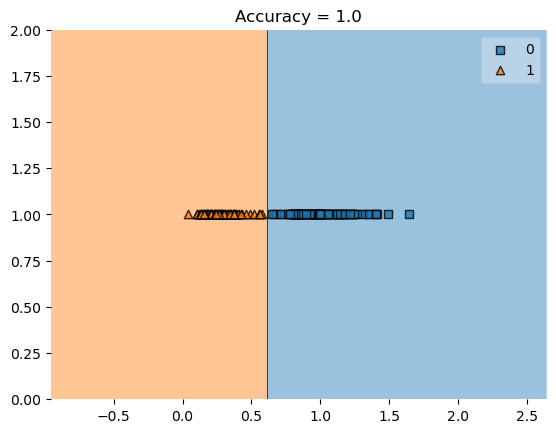

In [101]:

X, y = make_circles(200, shuffle = True, noise = 0.1, factor = 0.5)
#Transform X (there's probably a cleaner way to do this)
transformation = lambda x_1, x_2: x_1**2 + x_2**2
col1 = list(map(transformation, X[:, 0], X[:, 1]))
X[:, 0] = np.array(col1)
X[:, 1] = 1

LR = LogisticRegression()
LR.fit(X, y)
plot_decision_regions(X, y, clf = LR)
score = plt.gca().set_title(f"Accuracy = {LR.score(X, y)}")

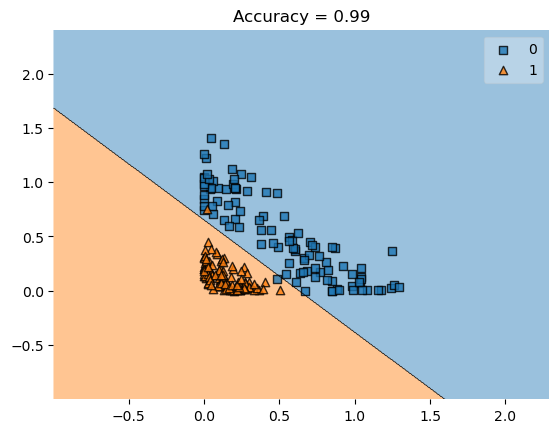

In [102]:

X, y = make_circles(200, shuffle = True, noise = 0.1, factor = 0.5)
#Transform X (there's probably a cleaner way to do this)
X = X**2

LR = LogisticRegression()
LR.fit(X, y)
plot_decision_regions(X, y, clf = LR)
score = plt.gca().set_title(f"Accuracy = {LR.score(X, y)}")